## Part 3: Creating custom report and figures

*by Morgane Desmau & Marco Alsina*

*Last update: May 2021*

This notebook explains the following steps:

1. Generating a custom report.
2. Generatiing a custom figure.
2. Saving a figure.

**Important:** This tutorial assumes you have succesfully completed the previous tutorials in the series:

- [Part 1: Basics of data processing](01.basics_data_processing.ipynb)
- [Part 2: Normalization and background removal](02.background_removal.ipynb)

In [1]:
# checking version of araucaria and dependencies
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.8b


### 1. Retrieving and summarizing the database

In this case we will be reading and processing a minerals database measured at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. Fe_database.h5

We will use the [get_testpath()](../testdata_module.rst#araucaria.testdata.utils.get_testpath) function to retrieve the filepath to the database and summarize its contents.

<div class="alert alert-info">
    
    **Note**
    
    If you prefer to process your own database, just modify the filepath to point to the location of your file.
</div>

In [2]:
# retrieving filepath
from pathlib import Path
from araucaria.testdata import get_testpath
from araucaria.io import summary_hdf5

fpath = get_testpath('Fe_database.h5')

# summarizing database
report = summary_hdf5(fpath)
report.show()

id  dataset                 mode    n   
1   FeIISO4_20K             mu      5   
2   Fe_Foil                 mu_ref  5   
3   Ferrihydrite_20K        mu      5   
4   Goethite_20K            mu      5   
5   Goethite_20K_10spectra  mu      10  


### 2. Generating a custom report

Here we will be analyzing the specrtra of Ferrihydrite and Goethite, and store the results in a custom [Report](../main/main_report.rst#araucaria.main.report.Report).

We will first declare the required dictionaries to perform spectral normalization and background removal.
This allows access and later modification of the parameters if needed, without changing our code for report generation and plotting.

Note that we also declare a function `maxindex()` to compute the index for the maximum value in an array.
We will be using this function to compute the maximum values on dXANES, XANES and $|\chi(R)|$ spectra.

In [3]:
import numpy as np
from scipy.signal import argrelextrema

# name of groups
groupnames = ('Goethite_20K', 'Ferrihydrite_20K')

# parameters for normalization, background removal, and foward fourrier transform
kw     = 2
win    = 'kaiser'

pre_edge_kws = {'pre_range' : [-160, -40],
                'post_range': [140, 950],
                'nvict'     : 2,
                'nnorm'     : 2,}

autobk_kws   = {'k_range'   : [0, 15],
                'kweight'   : kw,
                'rbkg'      : 1,
                'win'       : win,
                'dk'        : 0.1,
                'clamp_hi'  : 35,}

ftf_kws      = {'k_range'   : [2, 12],
                'kweight'   : kw,
                'win'       : win,}

def maxindex(data):
    '''Index of maximum value in an array
    '''
    index = argrelextrema(data, np.greater, order=100)[0]
    return index[0]

We now read and process the spectra, while storing the computed records in a [Report](../main/main_report.rst#araucaria.main.report.Report). Several steps are performed in a nested loop:

- The [read_hdf5()](../io/io_hdf5.rst#araucaria.io.io_hdf5.read_hdf5) function reads a [Group](../main/main_group.rst#araucaria.main.group.Group) from a HDF5 database.
- The [find_e0()](../xas/xas_normalize.rst#araucaria.xas.normalize.find_e0) function computes the absorpton threshold ($E_0$).
- The [pre_edge()](../xas/xas_normalize.rst#araucaria.xas.normalize.pre_edge) function normalizes the spectrum.
- The [autobk()](../xas/xas_autobk.rst#araucaria.xas.autobk.autobk) function performs background removal to obtain an EXAFS spectrum.
- The [xftf()](../xas/xas_ft.rst#araucaria.xas.xasft.xftf) function performs a fast forward Fourier transform of the EXAFS spectrum.
- The maximum values for the selected spectra are computed.
- The values are added to a [Report](../main/main_report.rst#araucaria.main.report.Report).
- The group is stored in a [Collection](../main/main_collection.rst#araucaria.main.collection.Collection).

Finally we print a summary of the custom [Report](../main/main_report.rst#araucaria.main.report.Report).

In [4]:
from araucaria import Report, Collection
from araucaria.io import read_hdf5
from araucaria.xas import find_e0, pre_edge, autobk, xftf

# initializing the report
report = Report()
col_names = ['Sample name', 'e0[eV]', 'Edmax[eV]','Emax[eV]', 'Rmax[A]']
report.set_columns(col_names)

# initializing a collection
collection = Collection()

for i, name in enumerate(groupnames):
    # reading and processing spectra
    data = read_hdf5(fpath, name=name)
    e0   = find_e0(data, method='halfedge', pre_edge_kws = pre_edge_kws, update = True)
    pre_edge(data, e0 = e0, update=True, **pre_edge_kws)
    autobk(data, update = True, **autobk_kws)
    xftf(data, update = True, **ftf_kws)

    # extracting maximum for dmu, mu, and chi(R)
    deriv_max_index = data.energy[maxindex(np.gradient(data.mu)/np.gradient(data.energy))]
    mu_max_index    = data.energy[maxindex(data.mu)]
    r_max_index     = data.r[maxindex(data.chir_mag)] 

    # adding content to the report
    report.add_row([groupnames[i], e0, deriv_max_index, mu_max_index, r_max_index])
    
    # add group to collection
    collection.add_group(data)

report.show()

Sample name       e0[eV]  Edmax[eV]  Emax[eV]  Rmax[A]  
Goethite_20K      7125.2  7127.3     7131      1.4726   
Ferrihydrite_20K  7124.8  7127.4     7132.6    1.4726   


### 3. Data visualization

We can now plot the data stored in the [Collection](../main/main_collection.rst#araucaria.main.collection.Collection) along with the computed values.

We use the [fig_xas_template()](../plot_module.rst#araucaria.plot.template.fig_xas_template) function to create a `Figure` and `axes` objects with the following attributes:

- 2 by 2 pre-defined panels for dXANES, XANES, EXAFS, and FT-EXAFS spectra.
- A dictionary to specify figure decorators (fig_pars). Note that we can also specifiy a `prop_cycle` dictionary to preset the color of the plots.
- A dictionary to specify general parameters for the figure (fig_kws). These arguments are passed directly to the `matplotlib` constructor.

Finally, we access the specific columns of the [Report](../main/main_report.rst#araucaria.main.report.Report) through the [get_cols()](../main/main_report.rst#araucaria.main.report.Report.get_cols) method.
Since data is stored as text, we convert it to `float` before plotting.

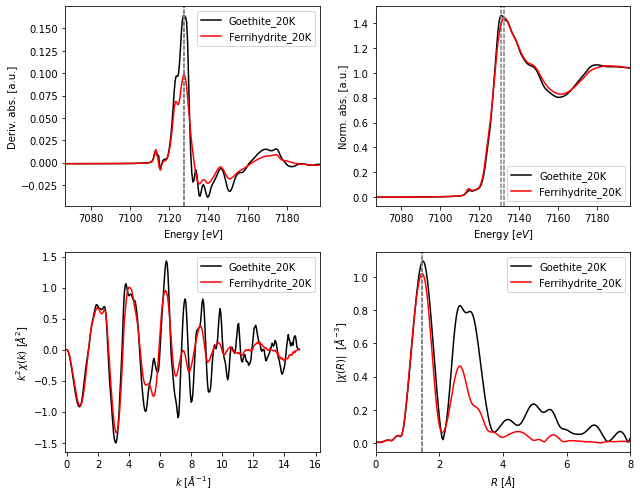

In [5]:
import matplotlib.pyplot as plt
from araucaria.plot import fig_xas_template

# figure parameters
k_edge   = 7112
fig_kws  = {'figsize'   : (9, 7)}  # figure size in inches
fig_pars = {'e_range'  : (k_edge-45, k_edge+85),
           'k_range'   : [-0.1, 16.3],
           'k_weight'  : kw,
           'k_ticks'   : np.linspace(0,16,9),
           'r_range'   : [0, 8],
           'r_ticks'   : np.linspace(0,8,5),
           'prop_cycle': [{'color'     : ['black', 'red'],
                           'linewidth' : [1.5    , 1.5  ],}]
           }
          
# initializing figure and axes
fig, axes = fig_xas_template(panels = 'dx/er', fig_pars = fig_pars, **fig_kws)

# extracting values from the report
dmu_max = report.get_cols(names=['Edmax[eV]'])
mu_max  = report.get_cols(names=['Emax[eV]'])
r_max   = report.get_cols(names=['Rmax[A]'])

# plotting data
for i, name in enumerate(groupnames):
    data = collection.get_group(name)

    # plotting spectra
    axes[0,0].plot(data.energy, np.gradient(data.mu)/np.gradient(data.energy), label = name)
    axes[0,1].plot(data.energy, data.flat, label = name)
    axes[1,0].plot(data.k, data.k**kw * data.chi, label = name)
    axes[1,1].plot(data.r, data.chir_mag, label = name)
    
    # plotting auxiliary lines
    axes[0,0].axvline(float(dmu_max[i]),0,1, dashes=[3,1], color = 'gray')
    axes[0,1].axvline(float(mu_max[i]) ,0,1, dashes=[3,1], color = 'gray')
    axes[1,1].axvline(float(r_max[i])  ,0,1, dashes=[3,1], color = 'gray')

for ax in np.ravel(axes):
    ax.legend()

fig.tight_layout()
plt.show()

The [fig_xas_template()](../plot_module.rst#araucaria.plot.template.fig_xas_template) function is quite flexible to generate figure templates.
Here we show the creation of panels in a single file to plot and annotate offset spectra.

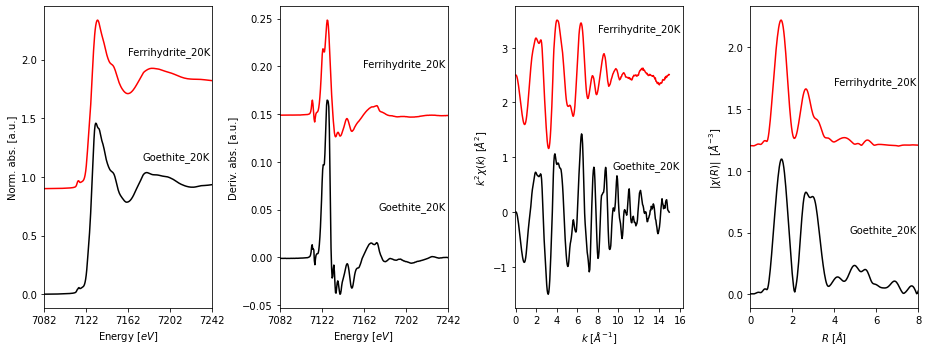

In [6]:
# figure parameters
steps    = [0.9, 0.15, 2.5, 1.2]
align    = 'right'
fsize    = 10
fig_kws  = {'figsize'   : (13, 5)}
fig_pars = {'e_range'   : (k_edge-30, k_edge+130),
            'e_ticks'   : [k_edge-30, k_edge+10, k_edge+50, k_edge+90, k_edge+130],
            'k_range'   : [-0.1,16.3],
            'k_weight'  : kw,
            'k_ticks'   : np.linspace(0,16,9),
            'r_range'   : [0, 8],
            'r_ticks'   : np.linspace(0,8,5),
            'prop_cycle': [{'color'     : ['black', 'red'],
                            'linewidth' : [1.5    , 1.5  ],}]
           }

# initializing figure and axes
fig, axes = fig_xas_template(panels = 'xder', fig_pars = fig_pars, **fig_kws)
    
# plotting data
for i, name in enumerate(groupnames):
    data = collection.get_group(name)
    
    # plotting spectra
    axes[0].plot(data.energy, i*steps[0] + data.norm) 
    axes[1].plot(data.energy, i*steps[1] + np.gradient(data.mu)/np.gradient(data.energy), 
                 label = name)
    axes[2].plot(data.k, i*steps[2] + data.k**2 * data.chi, label = name)
    axes[3].plot(data.r, i*steps[3] + data.chir_mag, label = name)

    # annotating spectra
    axes[0].text(7240, 1.15 + i*steps[0], s = name, ha=align, fontsize=fsize)    
    axes[1].text(7240, 0.05 + i*steps[1], s = name, ha=align, fontsize=fsize)
    axes[2].text(16  , 0.8  + i*steps[2], s = name, ha=align, fontsize=fsize)
    axes[3].text(7.9 , 0.5  + i*steps[3], s = name, ha=align, fontsize=fsize)

fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
plt.show()

### 4. Saving a figure

Figures in `araucaria` are produced with the `matplotlib` library.
Thus, we can save the resulting `Figure` object with the `savefig` method.

In [7]:
figpath = 'figure.pdf'
fig.savefig(figpath, bbox_inches='tight', dpi=300)
print ('Figure saved in %s' % figpath)

Figure saved in figure.pdf
